In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import itertools
from tqdm import tqdm
import random

import Environment
import Agent
%matplotlib inline

In [2]:
#Function which determines if car hits when it moves from state one to state two or not
def hit_obstacle(race, state, new_state):
    x_a, y_a = state
    x_b, y_b = new_state

    if x_a > x_b:
        min_x, max_x = x_b, x_a
    else:
        min_x, max_x = x_a, x_b

    if y_a > y_b: 
        min_y, max_y = y_b, y_a
    else:
        min_y, max_y = y_a, y_b

    dx = (max_x - min_x) + 1
    dy = (max_y - min_y) + 1
    temp = race.track[min_x:(min_x + dx),min_y:(min_y+dy)]

    for elem in temp.flatten():
        if elem==2:
            return True
    return False

In [3]:
last_ep = None

#Function to implement the Q-Learning algorithm
def QL_Algo(car, race, alpha = 0.5,discount_factor = 0.9, epsilon = 0.2, episodes = 50000, goals_desired = 10000):
    global last_ep

    #Initialize Q(S,A)
    states = list(itertools.product(range(race.m), range(race.n)))
    car.initialize(states,race)

    episode_number = 0
    goals_crossed = 0


    for episode_number in tqdm(range(episodes)):
        start_state = race.start()
        state = start_state
        action = car.get_action(state)
        car.update_velocity(action)
        reward = race.get_reward(state)
        velocity = car.velocity
        episode = [(state,action,velocity,reward)]

        new_state = race.update_state(state, car.velocity)
        hit = hit_obstacle(race, state, new_state)

        while (not race.is_terminal(new_state)) and (not hit):
            best_action = car.get_best_action(new_state)
            x = (state,action)
            x_star = (new_state,best_action)
            car.q[x] = car.q[x] + alpha*(reward + (discount_factor* car.q[x_star]) - car.q[x])

            reward = race.get_reward(new_state)
            state = new_state
            action = car.get_action(state)
            car.update_velocity(action)
            velocity = car.velocity

            new_state = race.update_state(state, car.velocity)
            hit = hit_obstacle(race,state,new_state)
            episode.append((state,action,velocity,reward))

    #Final Terminal state reward
        x = (state,action)
        car.q[x] = car.q[x] + alpha*(reward + (discount_factor * race.get_reward(new_state,hit)) - car.q[x])     

        car.reset()
        if hit == False:
            if new_state[0] >= race.m:        #acceleration caused car to go out of track crossing the finish line meanwhile
                goals_crossed += 1
                last_ep = (episode,new_state)

            if (0 <= new_state[0] < race.m) and (0 <= new_state[1] < race.n):
                if race.track[new_state[0], new_state[1]] == 3:
                    goals_crossed += 1
                    last_ep = (episode,new_state)


        if goals_crossed >= goals_desired:
            print ("Goals crossed surpassed goals desired to stop. Stopping Learning!")
            break

    return goals_crossed

In [4]:
def episode_to_dataframe(episode, end_state, end_reward):
    drive = {'Steps': [], 'State': [], 'Action': [], 'Velocity':[], 'Reward':[],}
    for i, ep in enumerate(episode):
        s, a,v, r = ep
        drive['Steps'].append(i+1)
        drive['State'].append(s)
        drive['Action'].append(a)
        drive['Velocity'].append(v)
        drive['Reward'].append(r)

    drive['Steps'].append(len(episode)+1)
    drive['State'].append(end_state)
    drive['Action'].append("X")
    drive['Velocity'].append("X")
    drive['Reward'].append(end_reward)

    result = pd.DataFrame(drive)
    return result

## Track-1

Creating the track using Race class from Environment.py

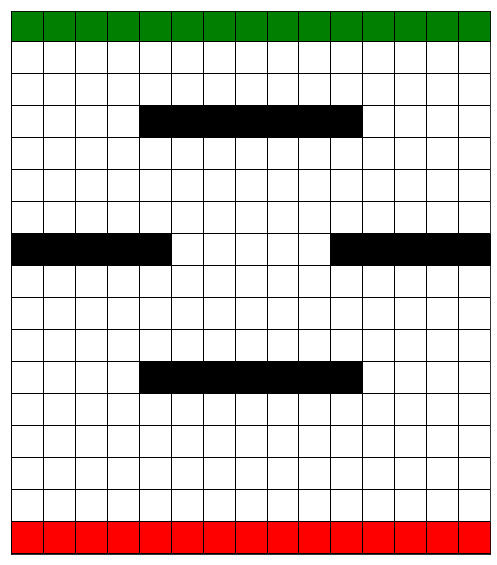

In [5]:
track1 = Environment.Race('track-1.txt')
track1.plot_track()

Initializing the car using Car class from Agent.py

In [6]:
car = Agent.Car()

In [7]:
QL_Algo(car, track1, alpha = 0.6, epsilon = 0.2, discount_factor = 0.95, episodes = 5000000)

100%|█████████████████████████████████████████████████████████████████████| 5000000/5000000 [04:38<00:00, 17957.15it/s]


162

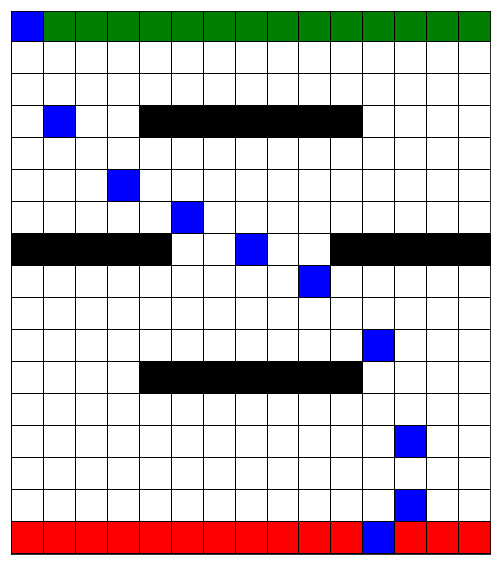

,Steps,State,Action,Velocity,Reward
0,1,"(0, 11)","(1, 1)","(1, 1)",-1
1,2,"(1, 12)","(1, -1)","(2, 0)",-1
2,3,"(3, 12)","(1, -1)","(3, -1)",-1
3,4,"(6, 11)","(-1, -1)","(2, -2)",-1
4,5,"(8, 9)","(-1, 0)","(1, -2)",-1
5,6,"(9, 7)","(0, 0)","(1, -2)",-1
6,7,"(10, 5)","(0, 0)","(1, -2)",-1
7,8,"(11, 3)","(1, 0)","(2, -2)",-1
8,9,"(13, 1)","(1, 1)","(3, -1)",-1
9,10,"(16, 0)",X,X,10


In [8]:
episode, end_state = last_ep
end_reward = track1.get_reward(end_state)
track1.plot_episode(episode, end_state)
episode_to_dataframe(episode,end_state,end_reward)

Out of 5M drives only **162** were able to finish the race.

So, lets try for other rewards

In [9]:
track1 = Environment.Race('track-1.txt',reward = 25)  #reward is set to 25 (i.e. steeper reward is 25 and penalty is 25)
car = Agent.Car()
QL_Algo(car, track1, alpha = 0.6, epsilon = 0.2, discount_factor = 0.95, episodes = 5000000)

 56%|███████████████████████████████████████▍                              | 2818764/5000000 [14:24<11:09, 3259.54it/s]

Goals crossed surpassed goals desired to stop. Stopping Learning!


10000

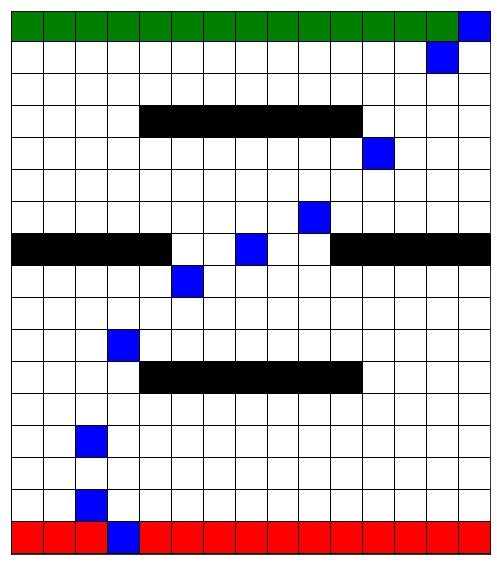

,Steps,State,Action,Velocity,Reward
0,1,"(0, 3)","(1, -1)","(1, -1)",-1
1,2,"(1, 2)","(1, 1)","(2, 0)",-1
2,3,"(3, 2)","(1, 1)","(3, 1)",-1
3,4,"(6, 3)","(-1, 1)","(2, 2)",-1
4,5,"(8, 5)","(-1, 0)","(1, 2)",-1
5,6,"(9, 7)","(0, 0)","(1, 2)",-1
6,7,"(10, 9)","(1, 0)","(2, 2)",-1
7,8,"(12, 11)","(1, 0)","(3, 2)",-1
8,9,"(15, 13)","(1, -1)","(4, 1)",-1
9,10,"(19, 14)",X,X,25


In [10]:
episode, end_state = last_ep
end_reward = track1.get_reward(end_state)
track1.plot_episode(episode, end_state)
episode_to_dataframe(episode,end_state,end_reward)

We can see than it covers more number of drives (infact **10000** which we want) which were able to finish the race.

So, for reward = 25 the algorithm will finish faster.

## Track-2

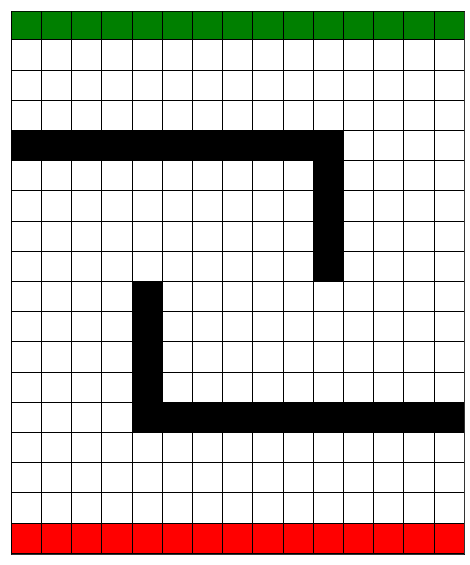

In [11]:
track2 = Environment.Race('track-2.txt')
track2.plot_track()

In [12]:
car = Agent.Car()
QL_Algo(car, track2, alpha = 0.6, epsilon = 0.2, discount_factor = 0.95, episodes = 5000000)

100%|█████████████████████████████████████████████████████████████████████| 5000000/5000000 [04:22<00:00, 19020.94it/s]


6

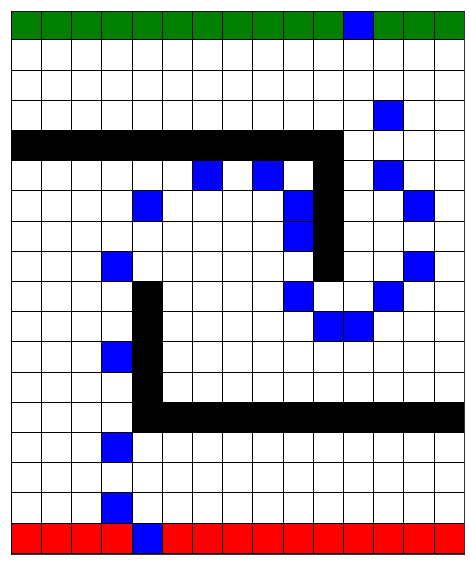

,Steps,State,Action,Velocity,Reward
0,1,"(0, 4)","(1, -1)","(1, -1)",-1
1,2,"(1, 3)","(1, 1)","(2, 0)",-1
2,3,"(3, 3)","(1, 0)","(3, 0)",-1
3,4,"(6, 3)","(0, 0)","(3, 0)",-1
4,5,"(9, 3)","(-1, 1)","(2, 1)",-1
5,6,"(11, 4)","(-1, 1)","(1, 2)",-1
6,7,"(12, 6)","(-1, 0)","(0, 2)",-1
7,8,"(12, 8)","(-1, -1)","(-1, 1)",-1
8,9,"(11, 9)","(0, -1)","(-1, 0)",-1
9,10,"(10, 9)","(-1, 0)","(-2, 0)",-1


In [13]:
episode, end_state = last_ep
end_reward = track2.get_reward(end_state)
track2.plot_episode(episode, end_state)
episode_to_dataframe(episode,end_state,end_reward)

Out of 5M drives only **6** were able to finish the race.

So, lets try for other rewards

In [14]:
track2 = Environment.Race('track-2.txt',reward = 30) #reward is set to 30 (i.e. steeper reward is 30 and penalty is 30)
car = Agent.Car()
QL_Algo(car, track2, alpha = 0.6, epsilon = 0.2, discount_factor = 0.95, episodes = 5000000)

100%|██████████████████████████████████████████████████████████████████████| 5000000/5000000 [26:16<00:00, 3171.94it/s]


5609

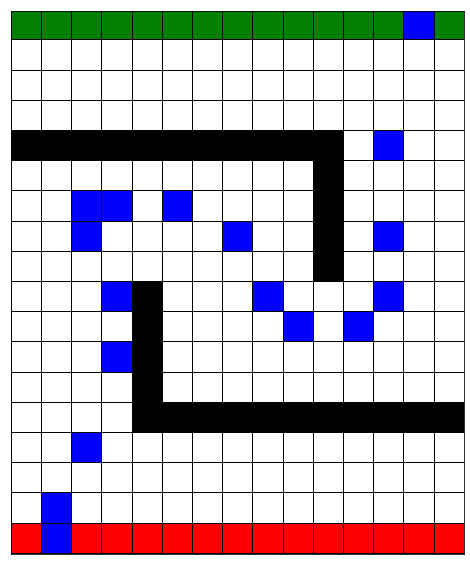

,Steps,State,Action,Velocity,Reward
0,1,"(0, 1)","(1, 0)","(1, 0)",-1
1,2,"(1, 1)","(1, 1)","(2, 1)",-1
2,3,"(3, 2)","(1, 0)","(3, 1)",-1
3,4,"(6, 3)","(-1, -1)","(2, 0)",-1
4,5,"(8, 3)","(0, -1)","(2, -1)",-1
5,6,"(10, 2)","(-1, 1)","(1, 0)",-1
6,7,"(11, 2)","(-1, 1)","(0, 1)",-1
7,8,"(11, 3)","(0, 1)","(0, 2)",-1
8,9,"(11, 5)","(-1, 0)","(-1, 2)",-1
9,10,"(10, 7)","(-1, -1)","(-2, 1)",-1


In [15]:
episode, end_state = last_ep
end_reward = track2.get_reward(end_state)
track2.plot_episode(episode, end_state)
episode_to_dataframe(episode,end_state,end_reward)

We can see than it covers more number of drives which were able to finish the race.

So, for reward = 30 the algorithm will finish faster.

## Own Track

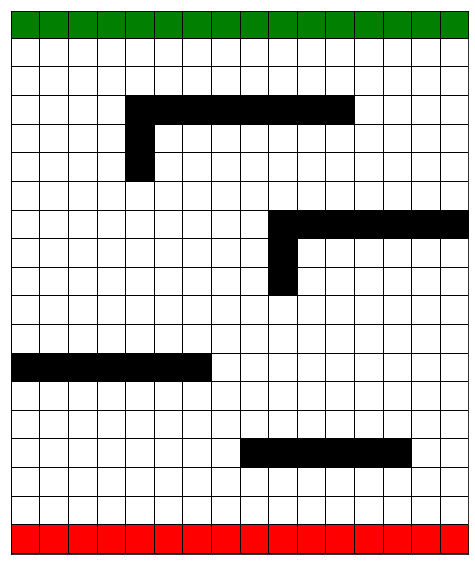

In [16]:
own_track = Environment.Race('track-own.txt')
own_track.plot_track()
car = Agent.Car()

In [17]:
QL_Algo(car, own_track, alpha = 0.6, epsilon = 0.2, discount_factor = 0.95, episodes = 5000000)

 57%|███████████████████████████████████████                              | 2829569/5000000 [02:45<02:07, 17073.01it/s]

Goals crossed surpassed goals desired to stop. Stopping Learning!


10000

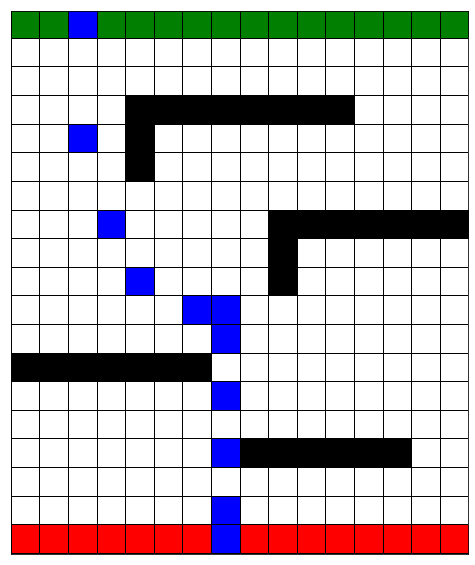

,Steps,State,Action,Velocity,Reward
0,1,"(0, 7)","(1, 0)","(1, 0)",-1
1,2,"(1, 7)","(1, 0)","(2, 0)",-1
2,3,"(3, 7)","(0, 0)","(2, 0)",-1
3,4,"(5, 7)","(0, 0)","(2, 0)",-1
4,5,"(7, 7)","(-1, 0)","(1, 0)",-1
5,6,"(8, 7)","(-1, -1)","(0, -1)",-1
6,7,"(8, 6)","(1, -1)","(1, -2)",-1
7,8,"(9, 4)","(1, 1)","(2, -1)",-1
8,9,"(11, 3)","(1, 0)","(3, -1)",-1
9,10,"(14, 2)","(1, 1)","(4, 0)",-1


In [18]:
episode, end_state = last_ep
end_reward = own_track.get_reward(end_state)
own_track.plot_episode(episode, end_state)
episode_to_dataframe(episode,end_state,end_reward)

**10000** drives finished without hitting. So, reward 10 will work here.